##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="#"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="#"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="#"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we will discuss how to classify cats vs dogs from images. We'll build an image classifier using **tf.keras**'s **Sequential** model and load data using **ImageDataGenerator**.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts
* **Building data input pipelines using the tf.keras's ImageDataGenerator Class** - how can we efficiently work with data on disk to interface with our model? 
* **Overfitting** - what is it, how to identify it, and how can we prevent it? 
* **Data Augmentation** and **Dropout** -  Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model. 

## We will follow the general machine learning workflow:
1. Examine and understand data
2. Build an input pipeline 
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

**Audience:** This post is geared towards beginners with some Keras API and ML background. To get the most out of this post, you should have some basic ML background and know what CNNs are.

# Importing packages

Let's start by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

The data we are using is initially available as ".zip" archive file. We are using **zipfile** to extract its contents.

In [0]:
import zipfile

Let's import **Tensorflow as tf** and from **tf.keras**, we need to import different methods to construct our model. Uses of all these methods will be explained as we progress with the tutorial.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In order to build our image classifier, we can begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


Redirecting output to ‘wget-log.3’.


After downloading the dataset, we need to extract its contents.

In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') # contents are extracted to '/tmp' folder
zip_ref.close()

The dataset we have downloaded has following directory structure. 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

After extracting its contents, we need to assign variables with the proper file path for training and validation set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

For convenience, let us set up variables that will be later used while pre-processing our dataset and training our network.

In [0]:
batch_size = 100
epochs = 15
IMG_SHAPE = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

Images should be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involving preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using a single class provided in **tf.keras** preprocessing module, called **ImageDataGenerator**. Not only it can read images from the disks and preprocess images into proper tensors, but it will also set up generators that will turn these images into batches of tensors, which will be very helpful while training our network as we need to pass our input to the network in the form of batches.

We can easily set up this using a couple of lines of code.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, 
                                                     directory=train_dir, 
                                                     # Its usually best practice to shuffle the training data
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150) 
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size, 
                                                              directory=validation_dir, 
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by using following lines of code which will first extract a batch of images from training generator, which is 32 images in our case and then we will plot 5 of them using **matplotlib**

In [0]:
sample_training_images, _ = next(train_data_gen) 

**next** function returns a batch from the dataset. The return value of **next** function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. We are discarding the labels in above situation because we only want to visualize our training images.

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

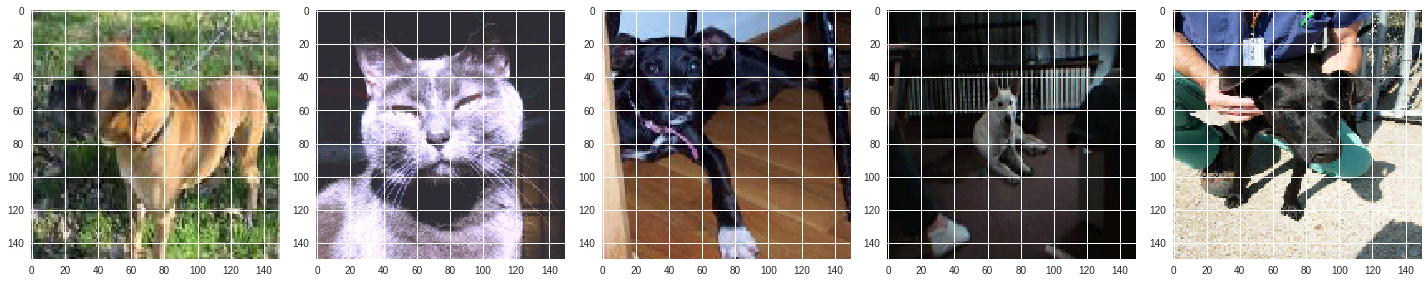

In [0]:
plotImages(sample_training_images[:5])

# Model Creation

The model consists of 3 convolution blocks with max pool layer in each of them. We have a fully connected layer with 512 units on top of it, which is activated by **relu** activation function. Model will output class probabilities based on binary classification which is done by **sigmoid** activation function. 

In [0]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3,))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compiling the model

We will use **ADAM** optimizer as our choice of optimizer for this task and **binary cross entropy** function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, for that we are passing it in the metrics argument.

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
__________

### Train the model

Its time we train our network. We will use **fit_generator** function to train our network instead of **fit** function, as we are using **ImageDataGenerator** class to generate batches of training and validation data for our network. 

In [0]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Epoch 1/15
20/20 [==============================] - 15s 747ms/step - loss: 0.9489 - acc: 0.5125 - val_loss: 0.6837 - val_acc: 0.5530
Epoch 2/15
20/20 [==============================] - 9s 454ms/step - loss: 0.6876 - acc: 0.5355 - val_loss: 0.6778 - val_acc: 0.5610
Epoch 3/15
20/20 [==============================] - 9s 471ms/step - loss: 0.6592 - acc: 0.6225 - val_loss: 0.6290 - val_acc: 0.6420
Epoch 4/15
20/20 [==============================] - 9s 466ms/step - loss: 0.5877 - acc: 0.7000 - val_loss: 0.5852 - val_acc: 0.7020
Epoch 5/15
20/20 [==============================] - 9s 466ms/step - loss: 0.5197 - acc: 0.7365 - val_loss: 0.5697 - val_acc: 0.7090
Epoch 6/15
20/20 [==============================] - 9s 470ms/step - loss: 0.4854 - acc: 0.7705 - val_loss: 0.6083 - val_acc: 0.6990
Epoch 7/15
20/20 [==============================] - 9s 472ms/step - loss: 0.4382 - acc: 0.7895 - val_loss: 0.5890 - val_acc: 0.6950
Epoch 8/15
20/20 [==============================] - 9s 471ms/step - loss: 0

### Visualizing results of the training

Let us now visualize the results we get after training our network.

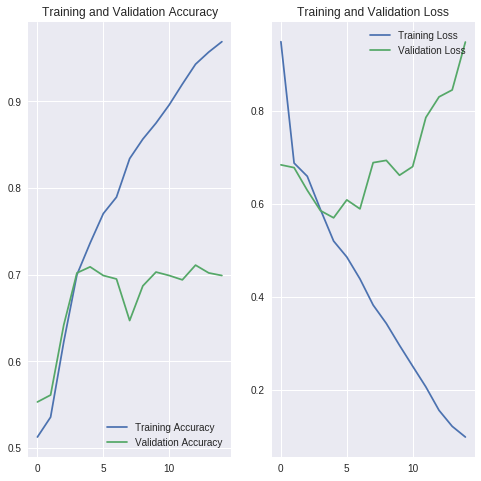

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set, let us analyse what went wrong there and try to increase overall performance of the model.

# Overfitting

If we look at the plots above, we can see that training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% after some time in our training process. Moreover, the difference in accuracy between training and validation accuracy is noticeably large. This is a sign of overfitting. 

When we have small number of training examples, our model sometimes learns from noises or unwanted details from our training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It simply means that our model will have a hard time generalizing well on a new dataset.

There are multiple ways to fight overfitting in our training process. Two of them is **Data Augmentation** and adding **Dropout** to our model. Let's start with Data Augmentation and see how it will help us to fight overfitting in our model.

To begin, we can clear our previous session and start with a new one.

In [0]:
# Clear resources
tf.keras.backend.clear_session()
epochs = 80

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass  different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process. 

## Augmenting and visualizing data

We can begin by applying random horizontal flip augmentation to our dataset and see how individual images will look like after the transformation.

### Applying Horizontal Flip

We can simply pass **horizontal_flip** as an argument to our ImageDataGenerator class and set it to **True** to apply this augmentation.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [0]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2000 images belonging to 2 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

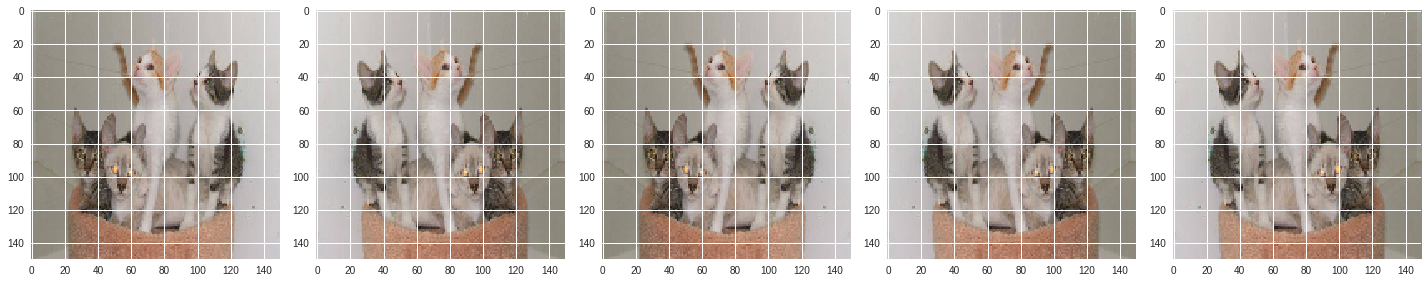

In [0]:
# Here, we are simply re-using the same custom plotting function 
# we defined and used above to visualize our training images
plotImages(augmented_images)

### Randomly rotating the image

Let's take a look at different augmentation called rotation and apply 45 degrees of rotation randomly to our training examples. 

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [0]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


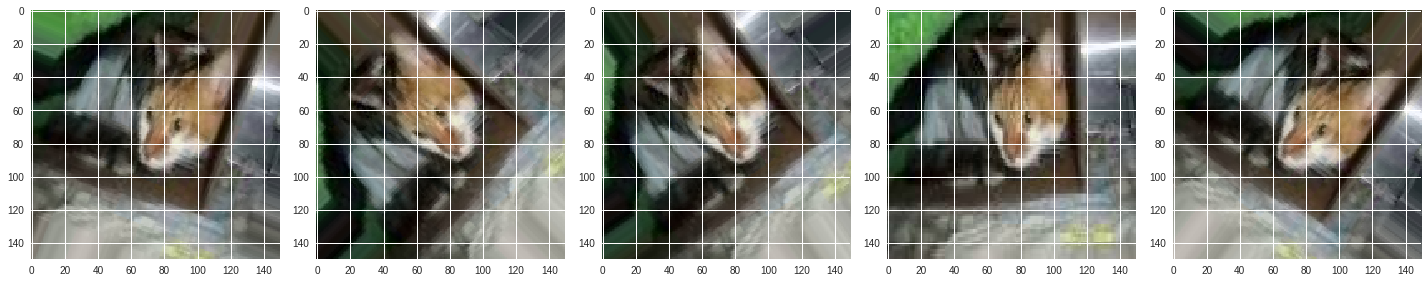

In [0]:
plotImages(augmented_images)

### Applying Zoom

Let's apply Zoom augmentation to our dataset to zoom images up to 50% randomly.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [0]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


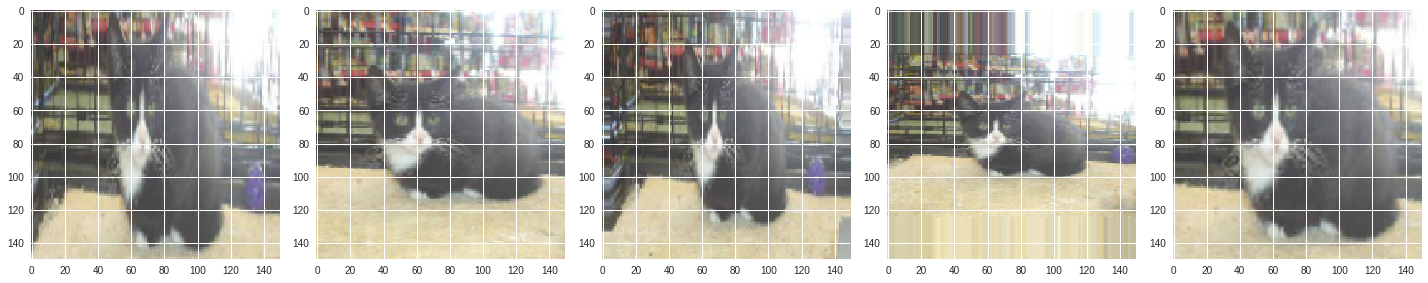

In [0]:
plotImages(augmented_images)

### Putting it all together

We can apply all the augmentations we saw above and even more with just one line of code. We can simply pass the augmentations as arguments with proper values and that would be all.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip and zoom augmentation to our training images.

In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5
                    )

In [0]:
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary'
                                                )

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

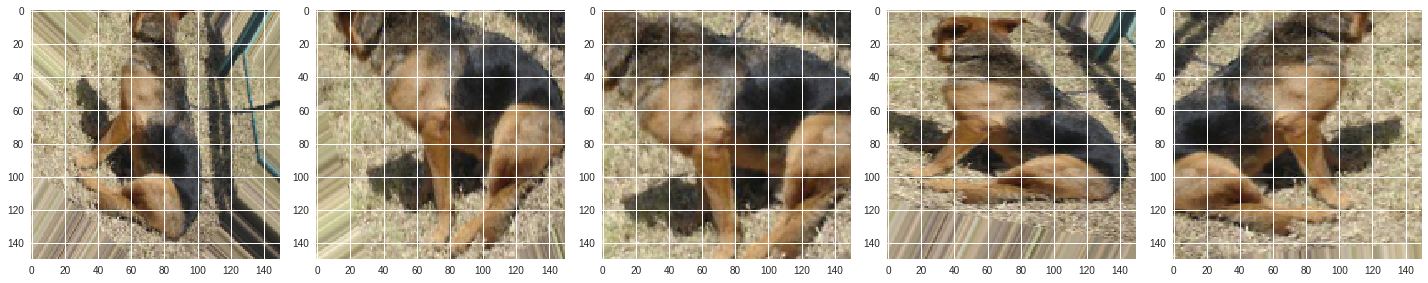

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [0]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, 
                                                 directory=validation_dir, 
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Dropout 

Another technique we can use to reduce overfitting is to introduce something called **Dropout** to our network. If you are not familiar with the term **regularization**, it simply means forcing the weights in your network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique we will be using in this tutorial.

When we apply Dropout to a layer it will randomly drop out (set to zero) number of output units from the applied layer during the training process. Dropout takes fraction number as its input value, in the form such as 0.1, 0.2, 0.4 etc. which simply means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. 

When we apply 0.1 value as a Dropout value to a certain layer, it will kill 10% of its output units randomly in each training epoch.

Let's create a network architecture with this new Dropout feature and apply it to different Convolutions and Fully Connected layers.

# Creating a new network with Dropouts

Here, we have applied Dropouts to first and last max pool layers and to a fully connected layer which has 512 output units. 30% of the first and last max pool layer and 10% of fully connected layer output units will be set to zero randomly during each epoch while training. 

In [0]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3,))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

### Compiling the model

After introducing Dropouts to our network, let us compile the model and see the layers summary.

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
__________

### Training the model

After successfully introducing Data Augmentations to our training examples and adding Dropouts to our network, let us now train this new network.

In [0]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Epoch 1/80
20/20 [==============================] - 25s 1s/step - loss: 1.2217 - acc: 0.4880 - val_loss: 0.6930 - val_acc: 0.5100
Epoch 2/80
20/20 [==============================] - 20s 1s/step - loss: 0.6931 - acc: 0.5110 - val_loss: 0.6918 - val_acc: 0.5720
Epoch 3/80
20/20 [==============================] - 20s 985ms/step - loss: 0.6887 - acc: 0.5320 - val_loss: 0.6855 - val_acc: 0.5520
Epoch 4/80
20/20 [==============================] - 20s 983ms/step - loss: 0.6818 - acc: 0.5525 - val_loss: 0.6756 - val_acc: 0.5150
Epoch 5/80
20/20 [==============================] - 20s 983ms/step - loss: 0.6543 - acc: 0.5935 - val_loss: 0.6709 - val_acc: 0.5690
Epoch 6/80
20/20 [==============================] - 20s 985ms/step - loss: 0.6473 - acc: 0.6220 - val_loss: 0.6536 - val_acc: 0.6160
Epoch 7/80
20/20 [==============================] - 20s 986ms/step - loss: 0.6334 - acc: 0.6455 - val_loss: 0.6731 - val_acc: 0.5940
Epoch 8/80
20/20 [==============================] - 20s 995ms/step - loss: 

### Visualizing the model

Let us visualize our new model after the training and see if we can find any sign of overfitting in it.

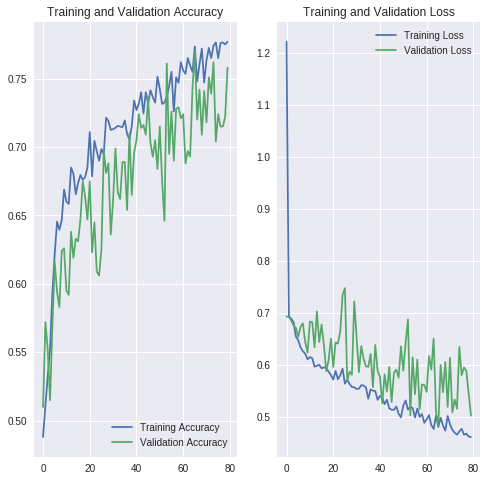

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluating our model
As we can see, our learning curves are much better than before and we don't see nearly as much overfitting as we did previously, and our model is able to achieve an accuracy of ~**75%**!

# Key Takeaways:

## What we covered in this tutorial:
* **Building data input pipelines using the ImageDataGenerator** - The ImageDataGenerator class allows us to easily load our data from the disk and efficiently add any arbitrary transformation to it. 
  * Training with a ImageDataGenerator is extremely easy as well
  * Working with ImageDataGenerator allows very powerful and fast transformation to be applied to your data
* **Overfitting** - Overfitting is a key problem that can severely harm your model's performance. Crucial techniques to know when combatting overfitting are **Dropout** and **Data Augmentation**
  * Dropout - is a powerful regularization technique that is found in almost every model 
  * Data Augmentation - is a cheap and powerful way to augment your dataset and allow your model to generalize to unseen data. 
